In [85]:
# %% [markdown]
# Analysis of Sample Runs
# This notebook loads samples from four runs, computes energies, and generates Ramachandran plots and energy histograms.

# %%
import time
import tqdm
import numpy as np
import torch
import dgl
import os
from bgflow.utils import remove_mean
from bgflow.utils import distances_from_vectors
from bgflow.utils import distance_vectors, as_numpy
from bgflow.bg import sampling_efficiency,unormalized_nll,effective_sample_size
from bgflow import XTBEnergy, XTBBridge
from models.interpolant import Interpolant
from models.ebm import GVP_EBM
from dataset.ad2_dataset import get_alanine_atom_types,get_alanine_implicit_dataset,get_alanine_features
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import mdtraj as md
import argparse
import wandb
from utils.arguments import get_args
from utils.utils import load_models
import ot


In [86]:
def plot_energy_distributions(energies_data_holdout,energies_np,log_w_np,weight_threshold=0,prefix=''):
    threshold_index=len(energies_np) - int(weight_threshold*len(energies_np)/100)
    energies_np=energies_np[np.argsort(log_w_np,axis=0)[:,0],:]
    energies_np=energies_np[:threshold_index,:]

    #log_w_np=log_w_np[np.argsort(log_w_np,axis=0)[:,0],:]
    log_w_np=np.sort(log_w_np,axis=0)
    log_w_np=log_w_np[:threshold_index]
    log_w_torch=torch.tensor(log_w_np)
    log_w_torch=log_w_torch - torch.logsumexp(log_w_torch,dim=(0,1))
    log_w_np=log_w_torch.numpy()

    plt.figure(figsize=(16,9))

    plt.hist(as_numpy(energies_data_holdout), bins=100, alpha=0.5, density=True, label="MD relaxed samples", range=(-120, 0))
    #plt.hist(energies_np, bins=100,range=(-34710, -34610) ,alpha=0.5, density=True, label="BG");
    plt.hist(energies_np, bins=100,range=(-120, 0) ,alpha=0.5, density=True, label="Boltzmann Emulator")
    plt.hist(energies_np, bins=50, density=True,  range=(-120, 0), alpha=0.4, histtype='step', linewidth=4,
            color="r", label="BoltzNCE weighted samples", weights=np.exp(log_w_np))
    plt.xticks(fontsize=25) 
    plt.yticks(fontsize=25)
    plt.legend(fontsize=30)
    plt.xlabel(r"Energy / $k_B T$", fontsize=45)  
    plt.title("Energy distribution", fontsize=45)      
    
    return energies_np,log_w_np

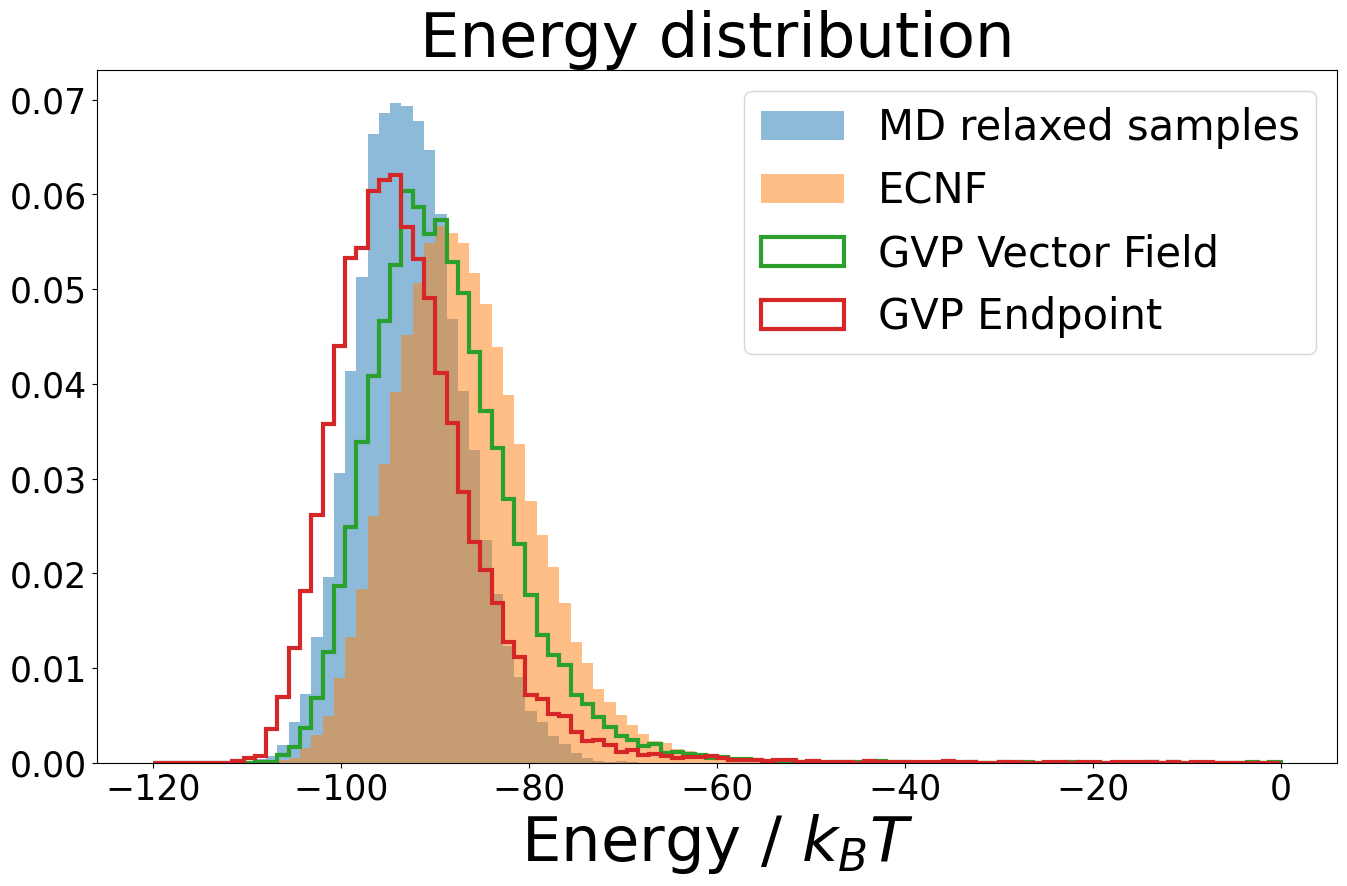

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Paths to your .npy files
file_map = {
    "MD relaxed samples": "../data/energies_data_holdout.npy",
    "TBG": "./generated/tbg_model_generated_energies.npy",
    # "GVP Vector Field No EMA": "./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
    "GVP Vector Field": "./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
    # "GVP Endpoint No EMA": "./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
    "GVP Endpoint": "./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
}


# Load all energy arrays into a dict
energies = {label: np.load(path) for label, path in file_map.items()}

# Plot everything on one histogram
plt.figure(figsize=(16, 9))
bins = 100
energy_range = (-120, 0)

# Plot the holdout set as filled bars
holdout_label = "MD relaxed samples"
plt.hist(
    energies[holdout_label],
    bins=bins,
    range=energy_range,
    density=True,
    alpha=0.5,
    label=holdout_label
)

plt.hist(
    energies["TBG"],
    bins=bins,
    range=energy_range,
    density=True,
    alpha=0.5,
    label="ECNF"
)

# Plot all generated distributions as line histograms
for label, data in energies.items():
    if label == holdout_label or label =="TBG":
        continue
    plt.hist(
        data,
        bins=bins,
        range=energy_range,
        density=True,
        histtype='step',
        linewidth=3,
        label=label
    )

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.xlabel(r"Energy / $k_B T$", fontsize=45)
plt.title("Energy distribution", fontsize=45)
plt.savefig("figures/energy_histogram.pdf",dpi=300,bbox_inches='tight')


In [ ]:
plt.figure(figsize=(8,6))
for name, energies in energies_dict.items():
    plt.hist(energies, bins=100, density=True, alpha=0.5, label=name)
plt.xlim(-120,-40)
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("Combined Energy Histogram for All Runs")
plt.legend(title="Run")
plt.show()



In [ ]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
from dataset.ad2_dataset import get_alanine_atom_types, get_alanine_implicit_dataset

# ─────────────── Constants & Indices ──────────────────
ATOM_TYPES = get_alanine_atom_types()
# remap certain indices so that atoms [4,6,8,14,16] become types 4–8
ATOM_TYPES[[4, 6, 8, 14, 16]] = np.arange(4, 9)
CARBON_POS = np.where(ATOM_TYPES == 1)[0]

PHI_INDICES = [4, 6, 8, 14]
PSI_INDICES = [6, 8, 14, 16]
PLOT_RANGE = [-np.pi, np.pi]
ENERGY_THRESHOLD = -75.0  # for filtering in the Ramachandran plot

# load once
dataset = get_alanine_implicit_dataset()
TOPOLOGY = dataset.system.mdtraj_topology


In [103]:

# ─────────────── Helper Functions ────────────────────
def determine_chirality_batch(coords_batch: np.ndarray) -> np.ndarray:
    """
    coords_batch: (n_samples, 4, 3) array of Cartesian coords,
                  where the first point is the chiral center and
                  the next three are the bonded atoms.
    Returns: array of 'L' or 'D' labels, shape (n_samples,)
    """
    # shift so center is at the origin
    vecs = coords_batch - coords_batch[:, :1, :]
    # normal to the first two bonds
    normals = np.cross(vecs[:, 1, :], vecs[:, 2, :])
    # dot with the third bond
    dots = np.einsum('ij,ij->i', normals, vecs[:, 3, :])
    return np.where(dots > 0.0, 'L', 'D')


def kde_fes(samples: np.ndarray, weights: np.ndarray, bw: float = 0.18, kBT: float = 1.0):
    """
    Compute FES via weighted Gaussian KDE.
    Returns grid (100 pts) and ΔF(grid).
    """
    kde = gaussian_kde(samples, bw_method=bw, weights=weights)
    grid = np.linspace(samples.min(), samples.max(), 100)
    fes = -kBT * kde.logpdf(grid)
    return grid, fes - fes.min()


def plot_ramachandran(samples: np.ndarray, energies: np.ndarray, weights: np.ndarray, title: str):
    """
    samples: (n,66) array; energies: (n,) or (n,1); weights: (n,)
    """
    n = samples.shape[0]
    coords = samples.reshape(n, 22, 3)
    # find Cβ per frame:
    cb_dists = np.linalg.norm(coords[:, 8:9, :] - coords[:, CARBON_POS, :], axis=2)
    closest = np.argmin(cb_dists, axis=1)
    cb_idx = CARBON_POS[closest]

    # build chirality coords (shape n×4×3)
    backbone = coords[:, [8, 6, 14], :]           # (n,3,3)
    cb_coords = coords[np.arange(n), cb_idx, :][:, None, :]  # (n,1,3)
    chirality = determine_chirality_batch(np.concatenate([backbone, cb_coords], axis=1))

    # mirror any D‐centers
    coords[chirality == 'D'] *= -1
    mapped = coords.reshape(n, 66)

    # # filter by energy for the Ramachandran plot
    # mask = energies.flatten() < ENERGY_THRESHOLD
    # traj = md.Trajectory(mapped[mask].reshape(-1, 22, 3), topology=TOPOLOGY)
    traj = md.Trajectory(mapped.reshape(-1, 22, 3), topology=TOPOLOGY)
    angles = md.compute_dihedrals(traj, [PHI_INDICES, PSI_INDICES])

    fig, ax = plt.subplots(figsize=(11, 9))
    # h, xedges, yedges, im = ax.hist2d(
    #     angles[:, 0], angles[:, 1],
    #     bins=100,
    #     norm=LogNorm(),
    #     cmin=1,
    #     range=[PLOT_RANGE, PLOT_RANGE],
    #     rasterized=True
    # )
    # free-energy ticks
    h, xedges, yedges, im = ax.hist2d(angles[:,0], angles[:,1], 100, norm=LogNorm(),cmin=1,  range=[PLOT_RANGE,PLOT_RANGE],rasterized=True)
    h=h[np.isfinite(h)]
    ticks = np.array([np.exp(-6)*h.max(), np.exp(-4)*h.max(),np.exp(-2)*h.max(), h.max()])
    levels = np.exp(-np.array([6, 4, 2, 0])) * h.max()
    ax.set_title(f"{title}", fontsize=55)
    ax.set_xlabel(r"$\varphi$", fontsize=55)
    ax.set_ylabel(r"$\psi$", fontsize=55)
    ax.tick_params(labelsize=20)

    cbar = fig.colorbar(im, ticks=ticks)
    cbar.ax.set_yticklabels(np.abs(-np.log(ticks/h.max())), fontsize=25)
    cbar.ax.invert_yaxis()
    cbar.ax.set_ylabel(r"Free energy / $k_B T$", fontsize=35)
    plt.tight_layout()
    plt.savefig(f"figures/{title}_no_filter_rama.pdf",bbox_inches="tight",dpi = 300)


def plot_free_energy_profile(samples: np.ndarray,
                             weights: np.ndarray,
                             title: str):
    """
    Overlays:
      • Umbrella-sampling reference FES
      • Your model’s KDE-based FES
      • MD-relaxed baseline FES
    """
    # reshape into (n_frames, 22, 3)
    n = samples.shape[0]
    coords = samples.reshape(n, 22, 3)
    traj_all = md.Trajectory(coords, topology=TOPOLOGY)
    phi = md.compute_phi(traj_all)[1].flatten()

    # Model KDE-FES
    # wrap-around trick
    phi_r = phi.copy()
    phi_l = phi.copy()
    phi_r[phi < 0] += 2 * np.pi
    phi_l[phi > np.pi / 2] -= 2 * np.pi

    gl, fl = kde_fes(phi_l, weights)
    gr, fr = kde_fes(phi_r, weights)

    mid = 1.1
    left_mask  = (gl >= -np.pi) & (gl < mid)
    right_mask = (gr <= np.pi)  & (gr >  mid)
    xs_model = np.hstack([gl[left_mask],  gr[right_mask]])
    fes_model = np.hstack([fl[left_mask], fr[right_mask]])

    # Umbrella-sampling reference
    umb = np.load("../data/ad2_umbrella_sampling_means.npz")
    xs_ref, fref_mean, fref_std = umb["xs"], umb["f_i_mean"], umb["f_i_std"]

    # MD-relaxed baseline
    md_raw = np.load("../data/AD2_relaxed_holdout.npy")[::9]
    md_coords = md_raw.reshape(-1, 22, 3)
    md_traj   = md.Trajectory(md_coords, topology=TOPOLOGY)
    md_phi    = md.compute_phi(md_traj)[1].flatten()
    w_md      = np.ones_like(md_phi)  # uniform weights
    grid_md, fes_md = kde_fes(md_phi, w_md)

    # Plot all three
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(xs_ref, fref_mean,      linewidth=3, label="Umbrella sampling")
    ax.fill_between(xs_ref, fref_mean - fref_std, fref_mean + fref_std, alpha=0.2)
    ax.plot(xs_model, fes_model,    "--",       linewidth=3, label=f"{title} KDE‐FES")
    ax.plot(grid_md, fes_md,        ":",        linewidth=2, label="MD-relaxed baseline")

    ax.set_title(f"{title} Free‐Energy Profile", fontsize=25)
    ax.set_xlabel(r"$\varphi$", fontsize=22)
    ax.set_ylabel(r"$\Delta F / k_B T$", fontsize=22)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    plt.tight_layout()
    plt.show()

    # ΔF comparison
    hist, edges = np.histogram(phi, bins=100, density=True, weights=weights)
    centers    = 0.5 * (edges[:-1] + edges[1:])
    in_region  = (centers > 0) & (centers < 2)
    ΔF = -np.log(hist[in_region].sum() / hist[~in_region].sum())
    print(f"{title}  predicted ΔF (0<φ<2 vs rest): {ΔF:.3f}")





--- Processing model: tbg ---


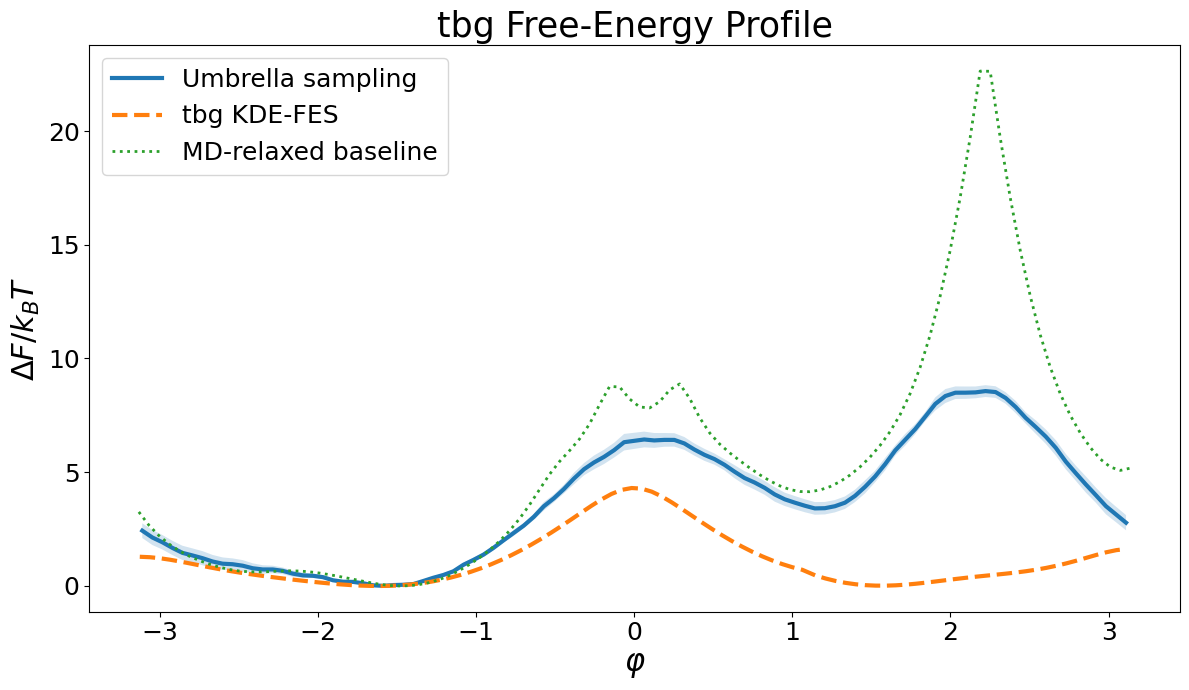

tbg  predicted ΔF (0<φ<2 vs rest): 0.717

--- Processing model: vector ---


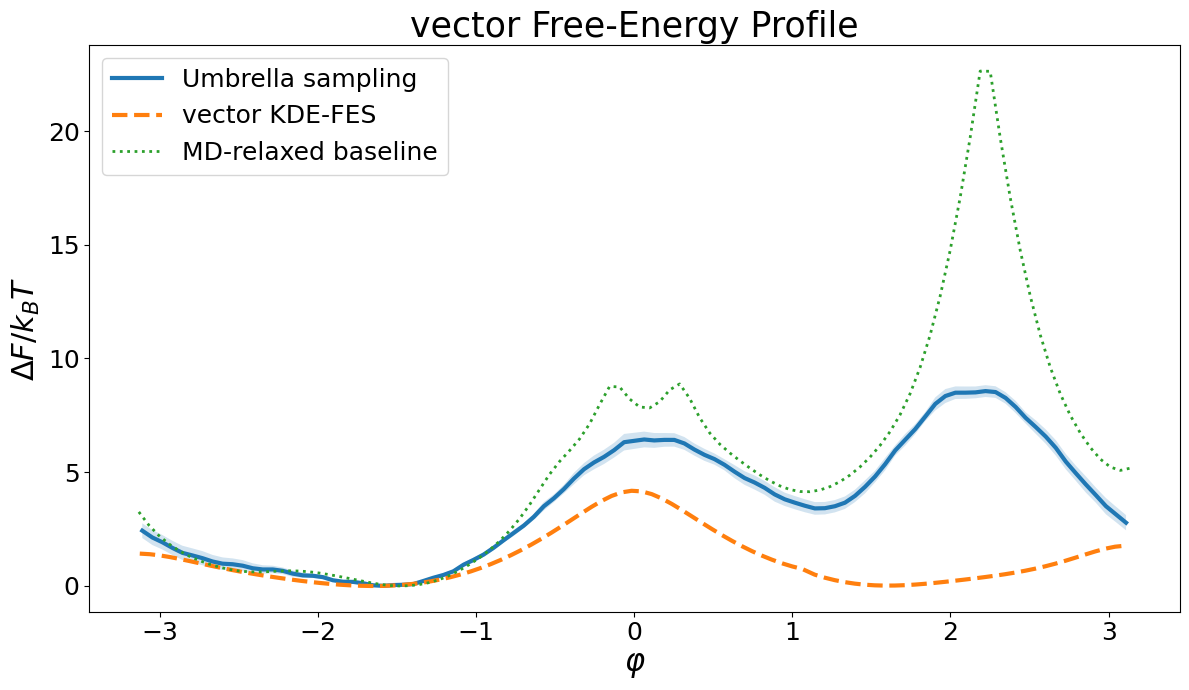

vector  predicted ΔF (0<φ<2 vs rest): 0.704

--- Processing model: vector_ema ---


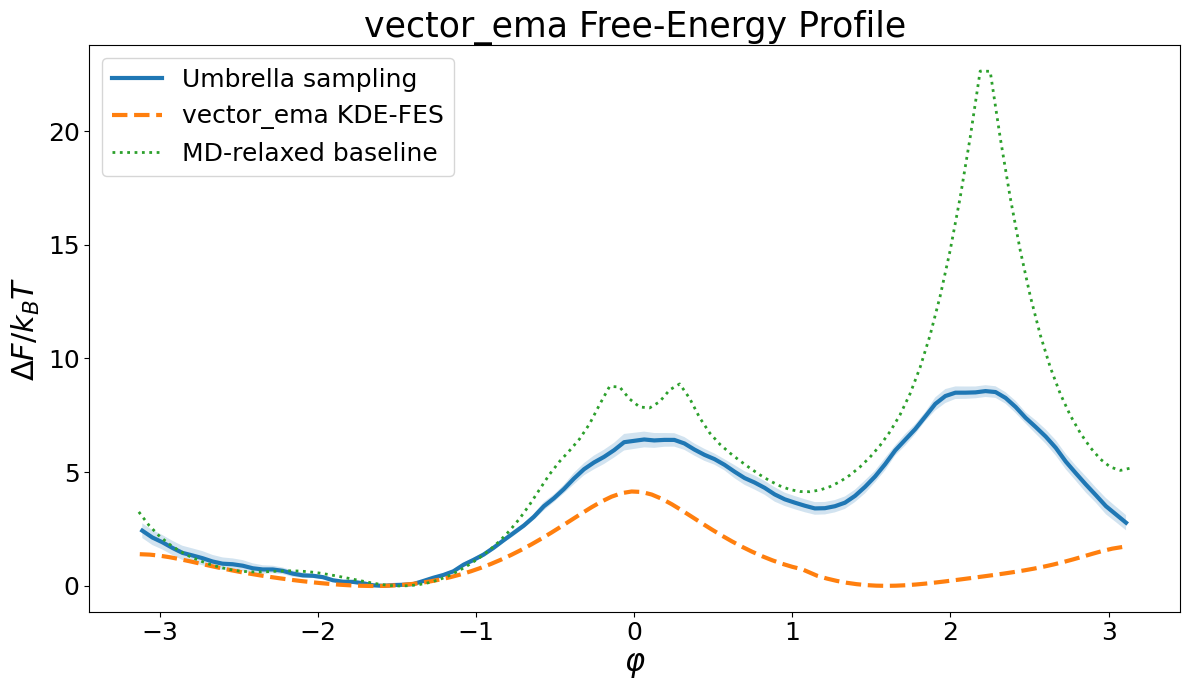

vector_ema  predicted ΔF (0<φ<2 vs rest): 0.690

--- Processing model: endpoint ---


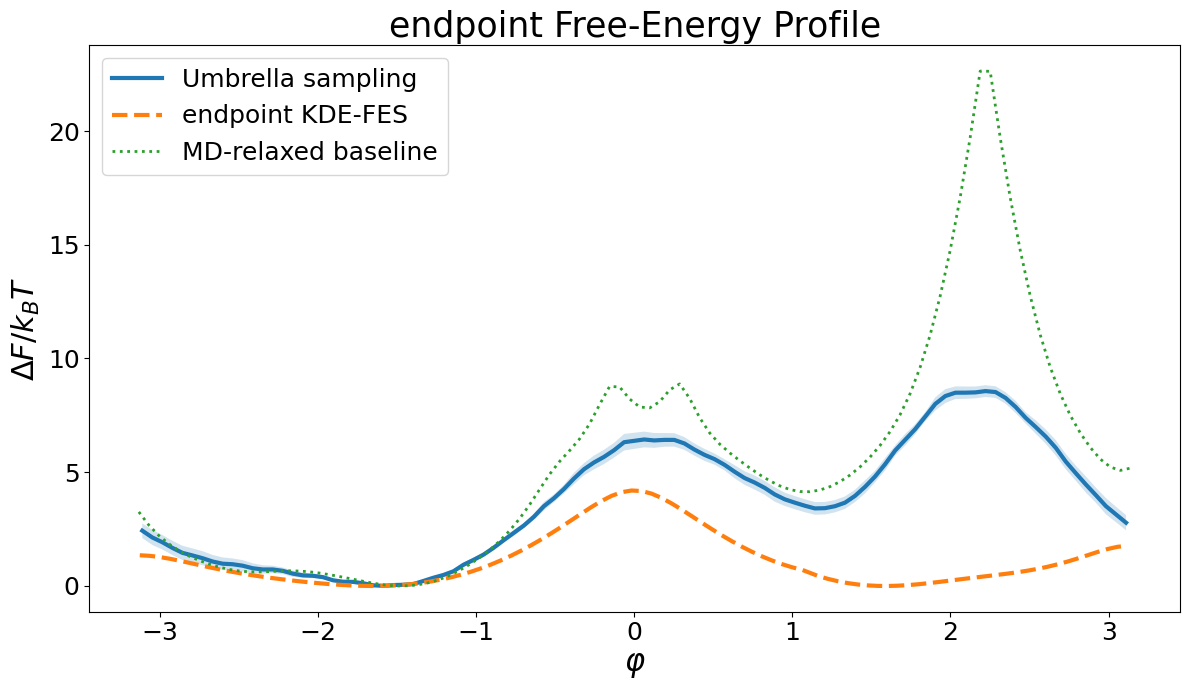

endpoint  predicted ΔF (0<φ<2 vs rest): 0.688

--- Processing model: endpoint_ema ---


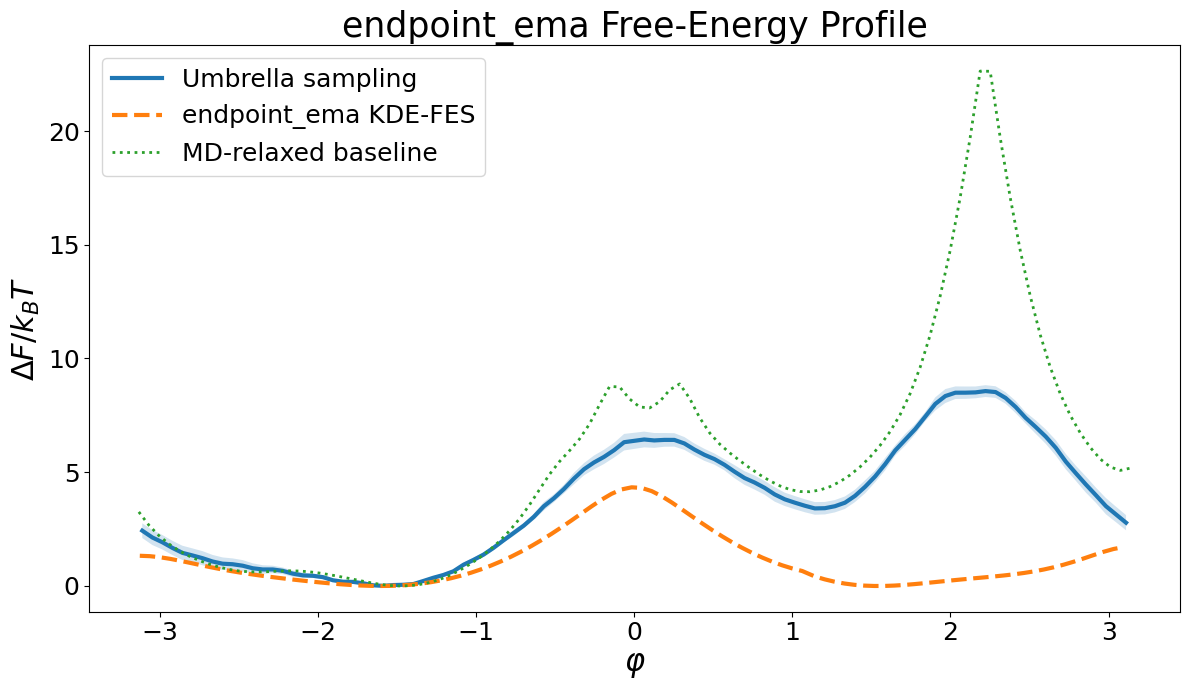

endpoint_ema  predicted ΔF (0<φ<2 vs rest): 0.708

--- Processing model: MD relaxed samples ---


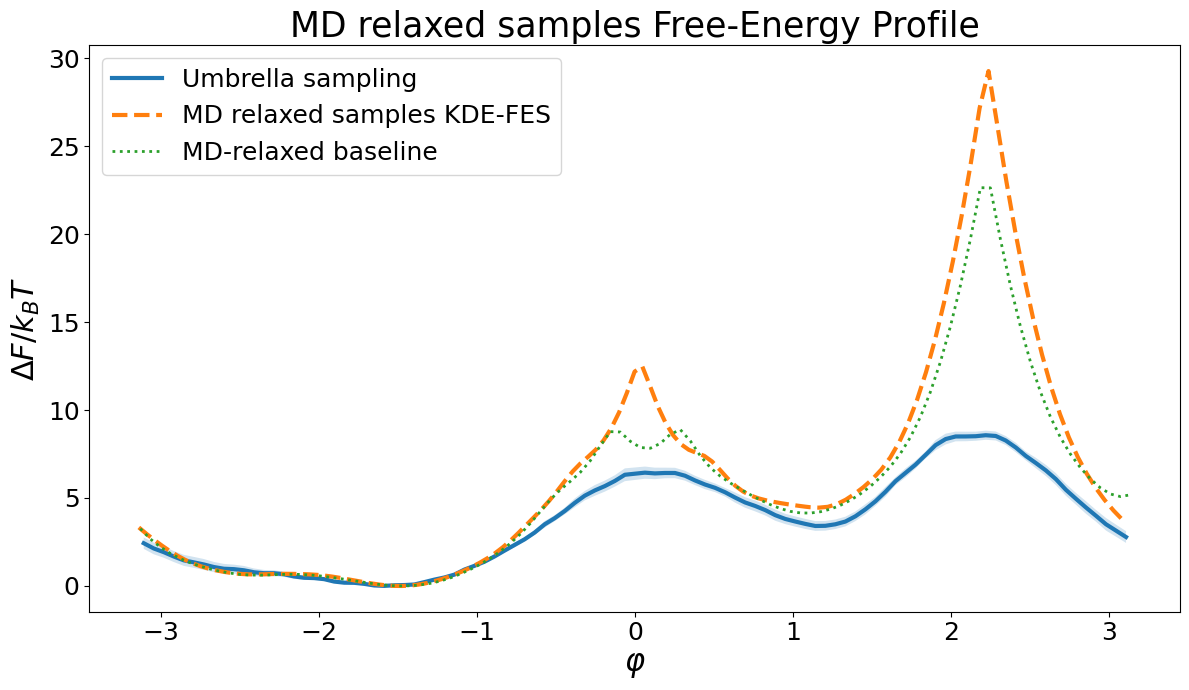

MD relaxed samples  predicted ΔF (0<φ<2 vs rest): 5.075


In [57]:


file_map = {
    "tbg":        ("./generated/tbg_model_generated_energies.npy",      "./generated/tbg_model_generated_samples.npy"),
    "vector":     ("./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
                   "./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0samples.npy"),
    "vector_ema": ("./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
                   "./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0samples.npy"),
    "endpoint":   ("./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0samples.npy"),
    "endpoint_ema":("./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0samples.npy"),
    "MD relaxed samples": ("../data/energies_data_holdout.npy","../data/AD2_relaxed.npy")
}

for name, (e_path, s_path) in file_map.items():
    print(f"\n--- Processing model: {name} ---")
    energies = np.load(e_path)
    samples  = np.load(s_path)
    # uniform log‐weights → exp(log_w)=1
    log_w = np.zeros((energies.shape[0],))
    if name == "MD relaxed samples":
        samples  = np.load(s_path)[::9]
    
    
    # plot_ramachandran(samples, energies, np.exp(log_w), title=name)
    plot_free_energy_profile(samples, np.exp(log_w), title=name)

In [ ]:
energies_holdout_file = "../data/energies_data_holdout_all.npy"
scaling=10
atom_types_xtb = get_alanine_atom_types()
temperature = 300
number_dict = {0: 1, 1:6, 2:7, 3:8}
numbers = np.array([number_dict[atom_type] for atom_type in atom_types_xtb])
target_xtb = XTBEnergy(
    XTBBridge(numbers=numbers, temperature=temperature, solvent="water"),
    two_event_dims=False
)
# energies_np = as_numpy(target_xtb.energy(torch.from_numpy(samples)/scaling))
energy_offset = 34600

    # if we already computed it, just load
if os.path.exists(energies_holdout_file):
    energies_data_holdout = np.load(energies_holdout_file)
    # if you need it back as a torch tensor:
    energies_data_holdout = torch.from_numpy(energies_data_holdout)
else:
    # otherwise compute it...
    data_holdout_xtb = torch.from_numpy(
        np.load("../data/AD2_relaxed_holdout.npy")
    ).reshape(-1, 66)
    energies_data_holdout = target_xtb.energy(data_holdout_xtb/ scaling)
    energies_data_holdout += energy_offset
    energies_data_holdout = energies_data_holdout.detach().cpu().numpy()
    np.save(energies_holdout_file, energies_data_holdout)


In [ ]:
energies_data_holdout = energies_data_holdout.detach().cpu().numpy()
np.save(energies_holdout_file, energies_data_holdout)


--- Processing model: ECNF ---

--- Processing model: GVP Vector No EMA ---

--- Processing model: GVP Vector Field ---

--- Processing model: GVP Endpoint No EMA ---

--- Processing model: GVP Endpoint ---

--- Processing model: MD Relaxed ---

--- Processing model: Biased MD Relaxed ---


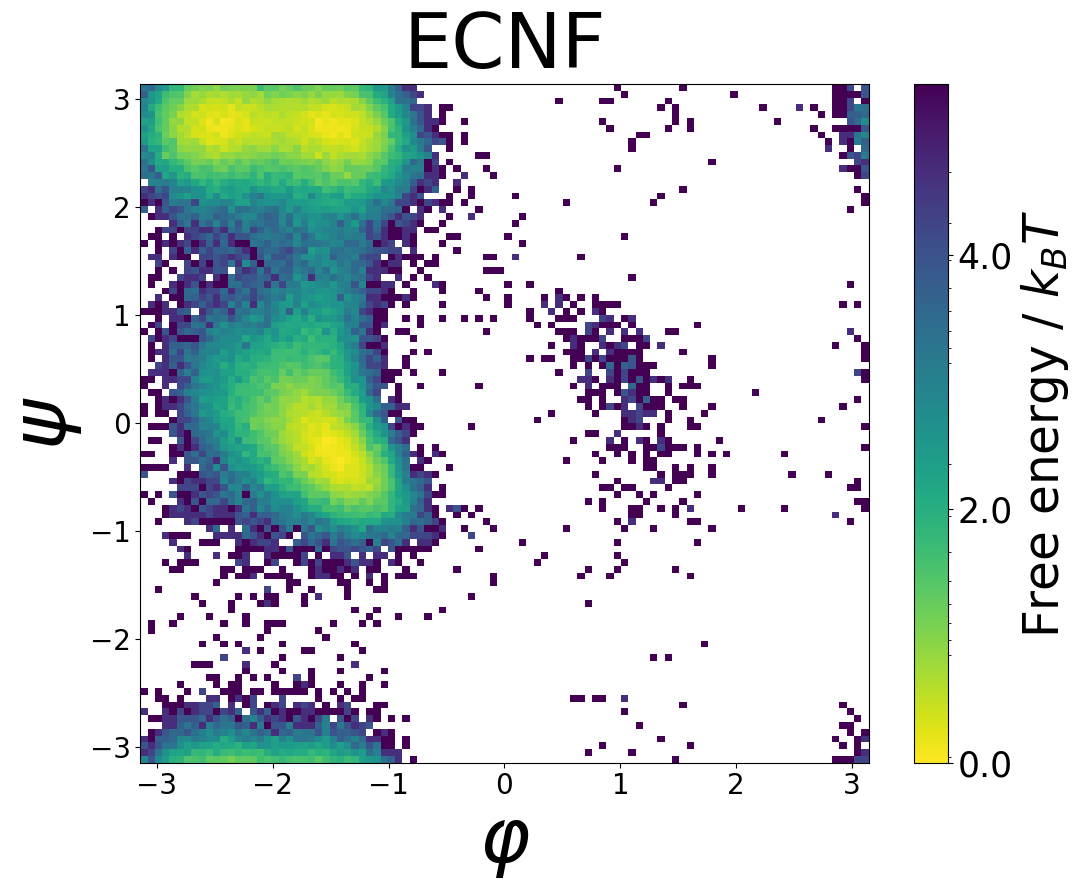

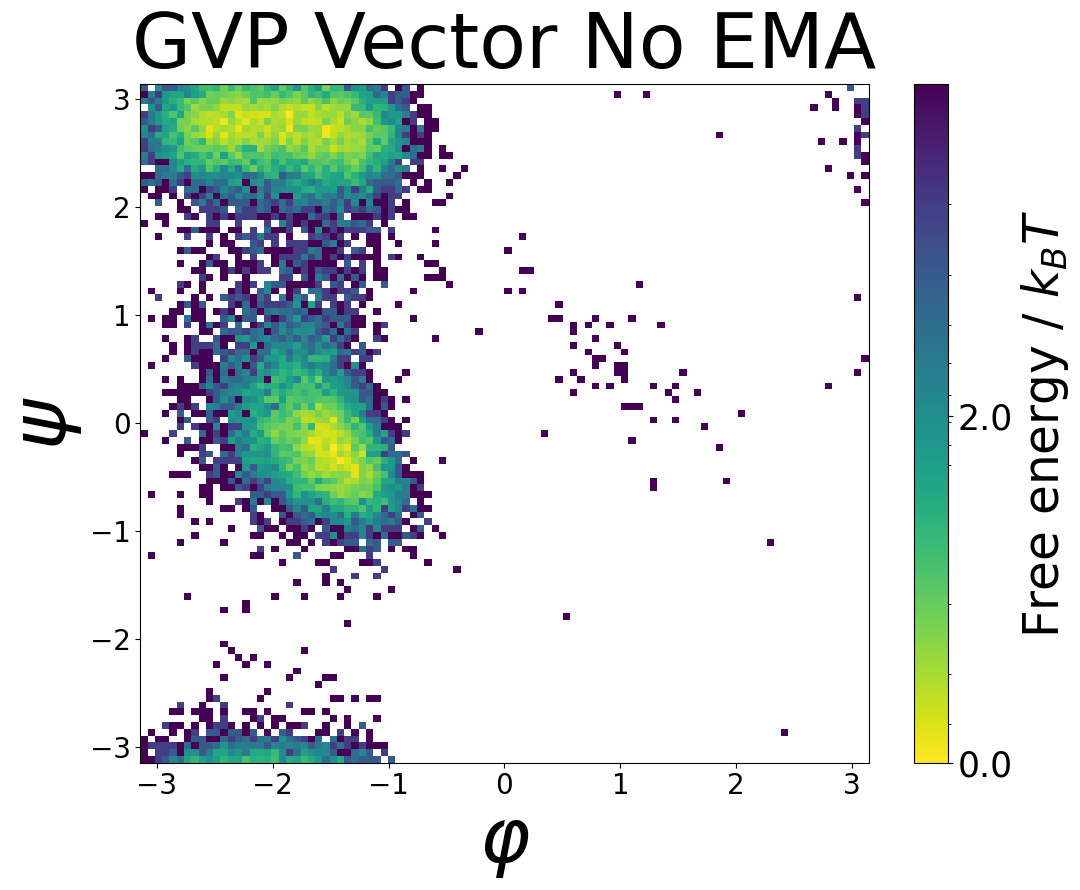

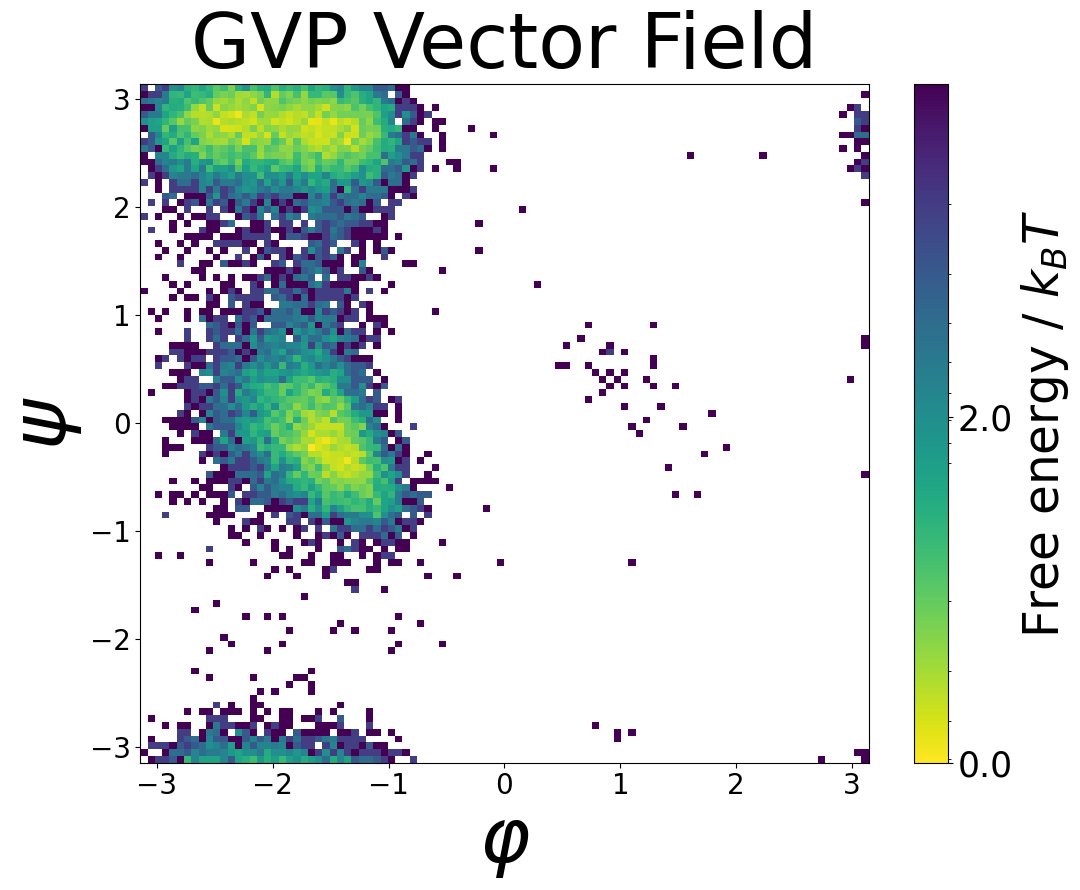

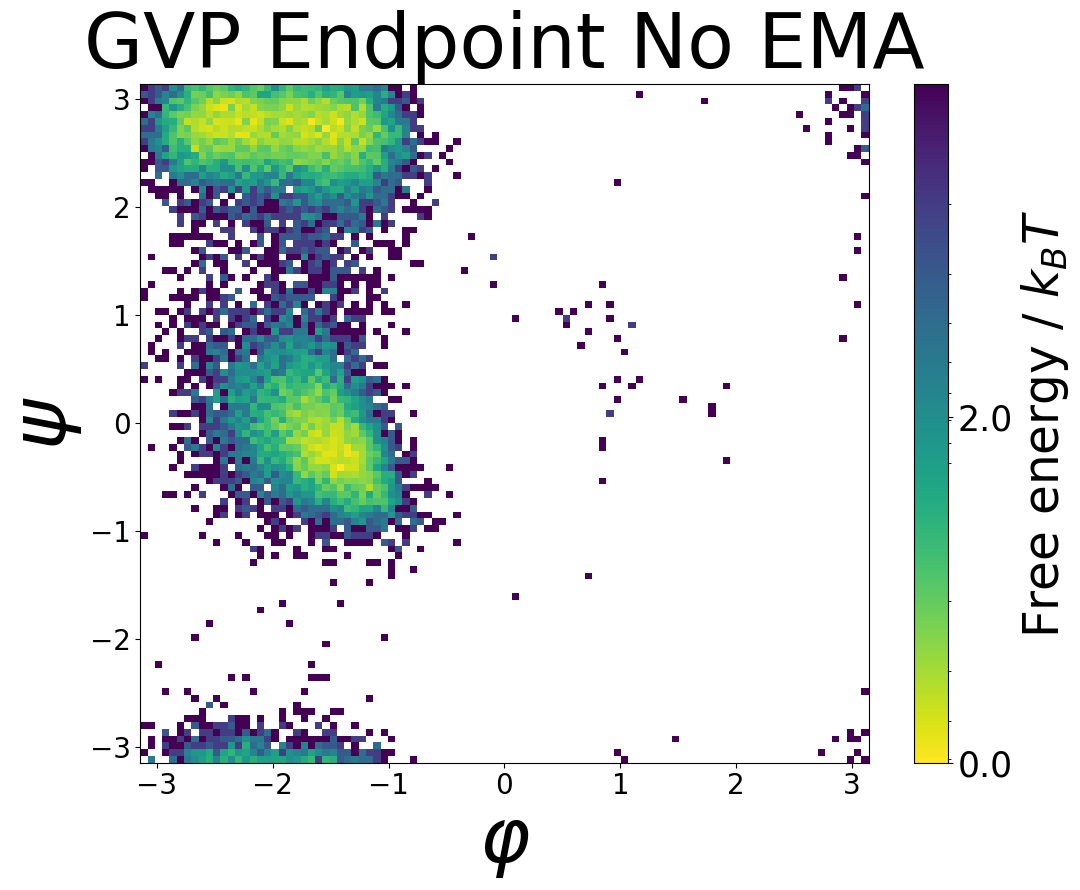

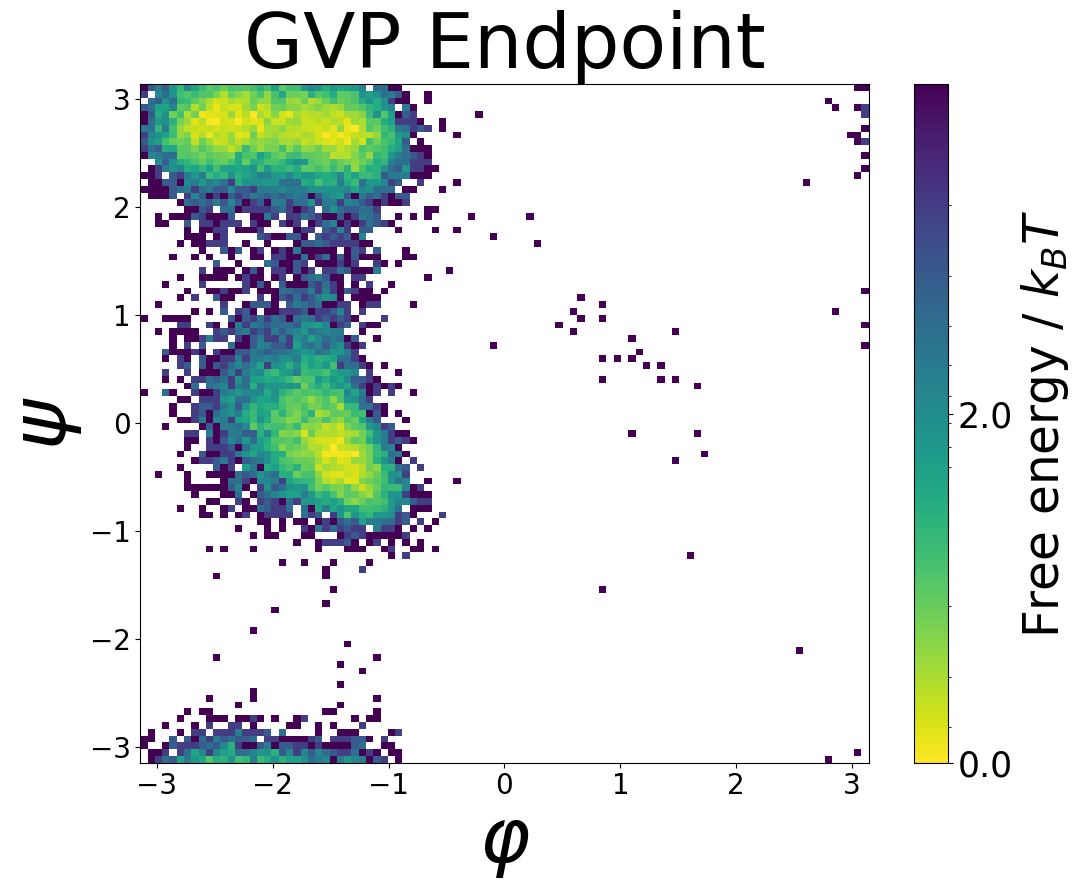

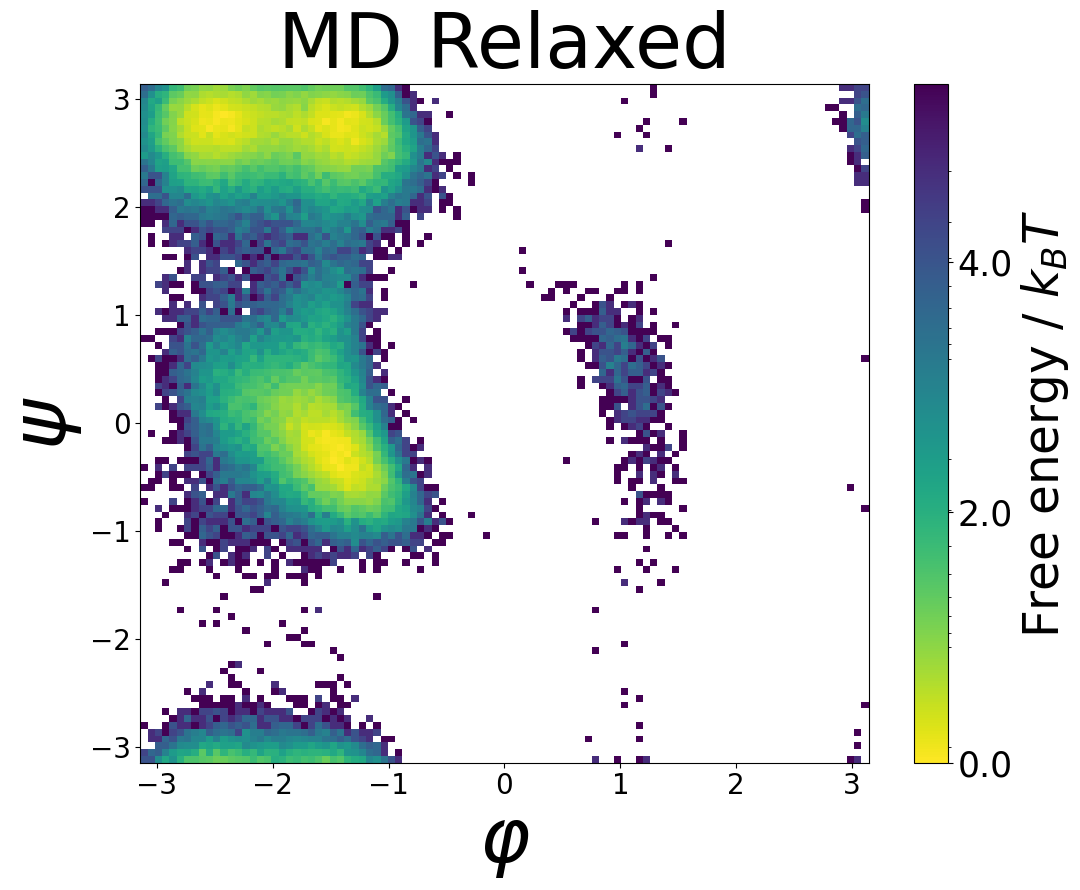

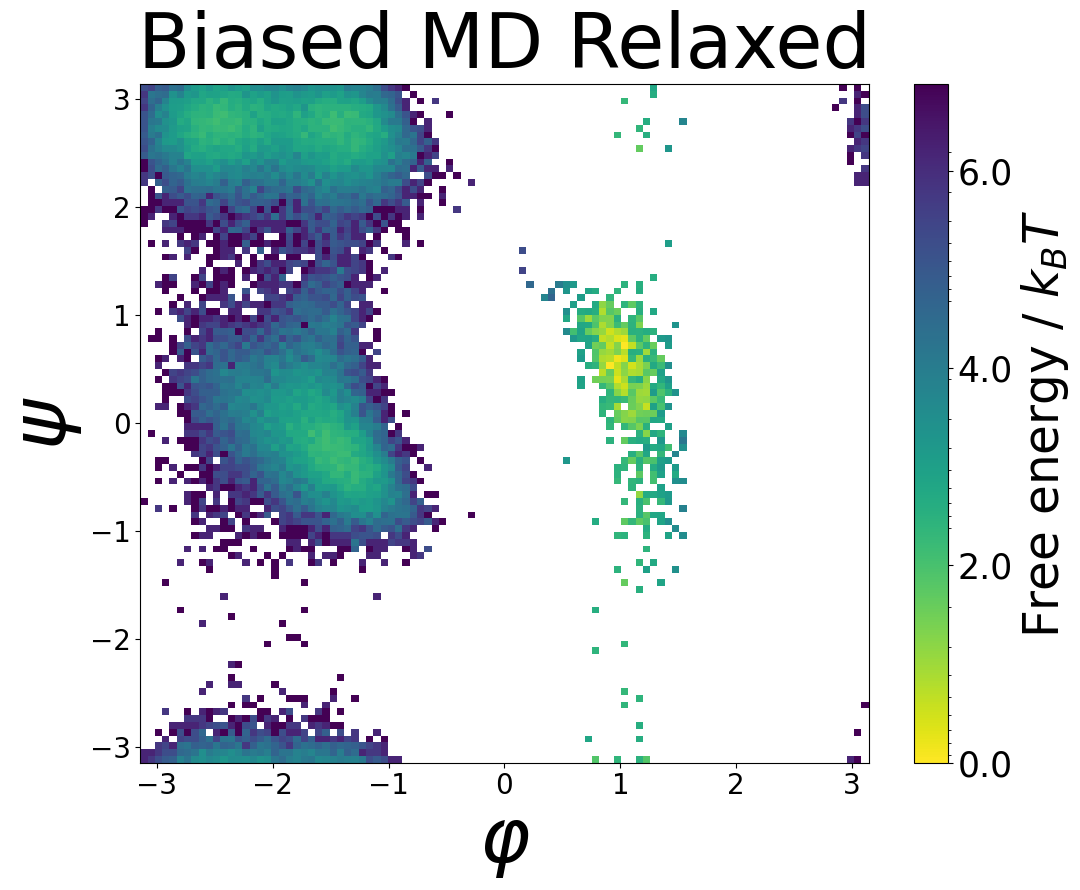

In [101]:


file_map = {
    "ECNF":        ("./generated/tbg_model_generated_energies.npy",      "./generated/tbg_model_generated_samples.npy"),
    "GVP Vector No EMA":     ("./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
                   "./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0samples.npy"),
    "GVP Vector Field": ("./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0energies.npy",
                   "./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0samples.npy"),
    "GVP Endpoint No EMA":   ("./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0samples.npy"),
    "GVP Endpoint":("./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0energies.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0samples.npy"),
    "MD Relaxed": ("../data/energies_data_holdout_all.npy","../data/AD2_relaxed.npy"),
    "Biased MD Relaxed": ("../data/AD2_relaxed_weighted_all_energies.npy","../data/AD2_relaxed_weighted.npy")
}

for name, (e_path, s_path) in file_map.items():
    print(f"\n--- Processing model: {name} ---")
    energies = np.load(e_path)
    samples  = np.load(s_path)
    # uniform log‐weights → exp(log_w)=1
    log_w = np.zeros((energies.shape[0],))
    if name == "MD relaxed samples":
        samples  = np.load(s_path)
    
    
    plot_ramachandran(samples, energies, np.exp(log_w), title=name)
    # plot_free_energy_profile(samples, np.exp(log_w), title=name)

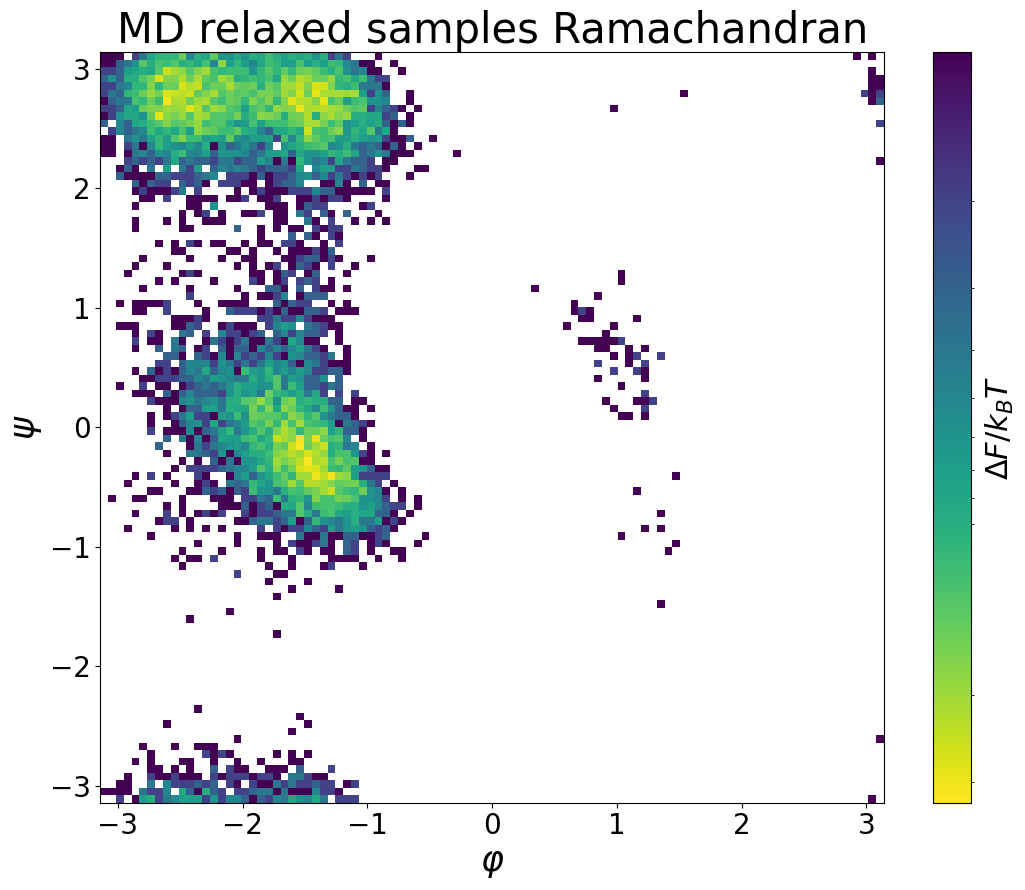

In [66]:
    plot_ramachandran(samples, energies, np.exp(log_w), title=name)
plt.savefig("figures/MD_rama.pdf",bbox_inches="tight",dpi=300)


--- Processing model: ECNF ---

--- Processing model: GVP Vector No EMA ---

--- Processing model: GVP Vector Field ---

--- Processing model: GVP Endpoint No EMA ---

--- Processing model: GVP Endpoint ---

--- Processing model: MD Relaxed ---

--- Processing model: Biased MD Relaxed ---


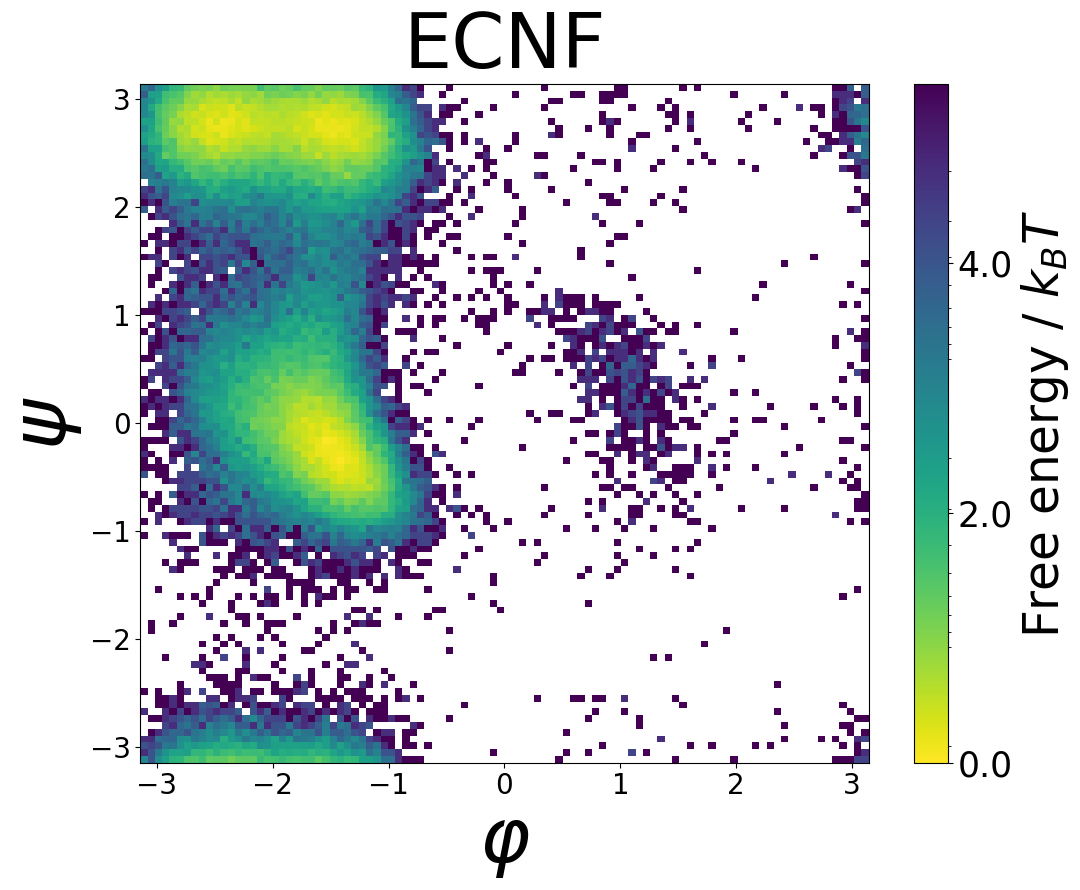

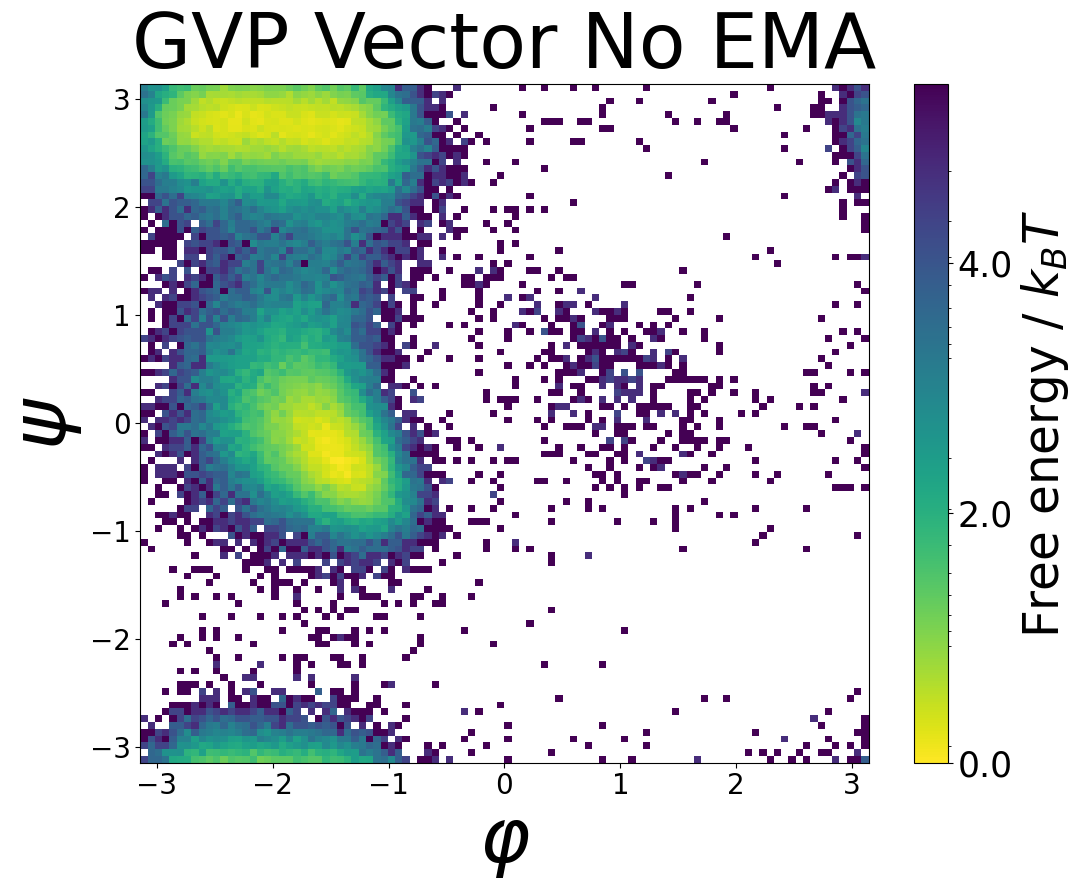

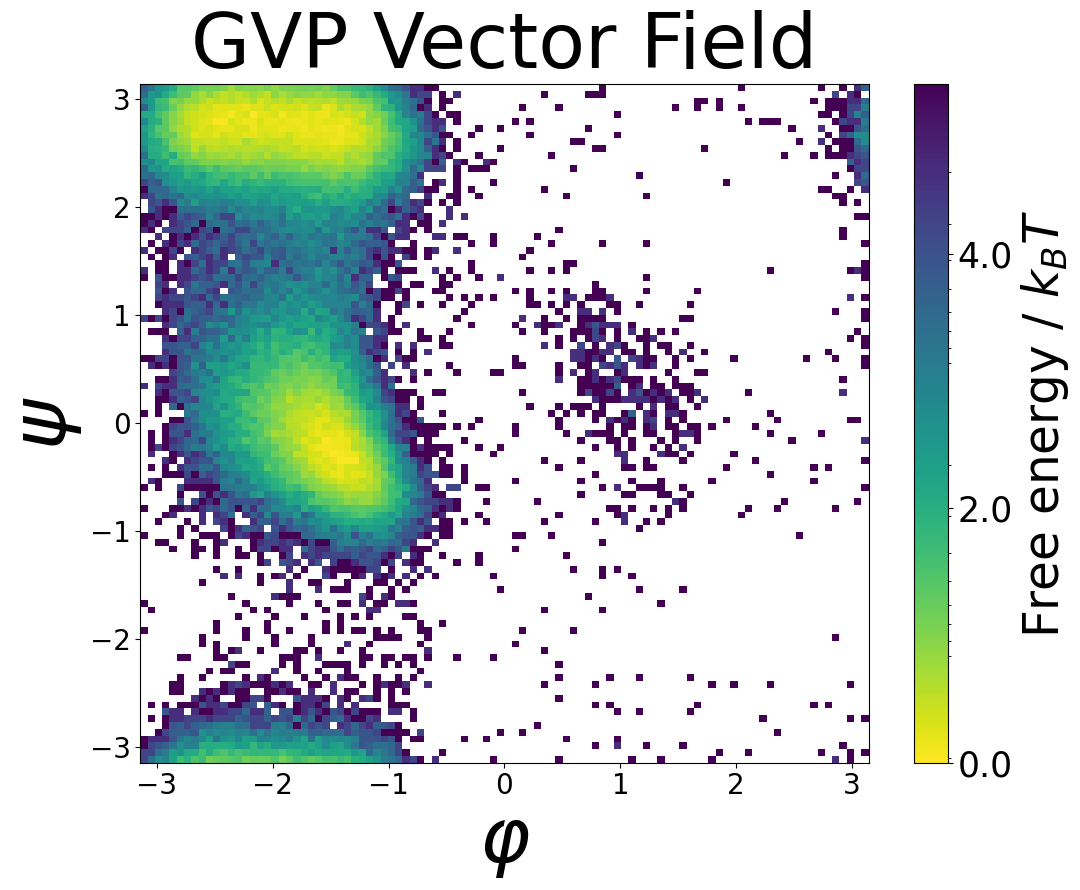

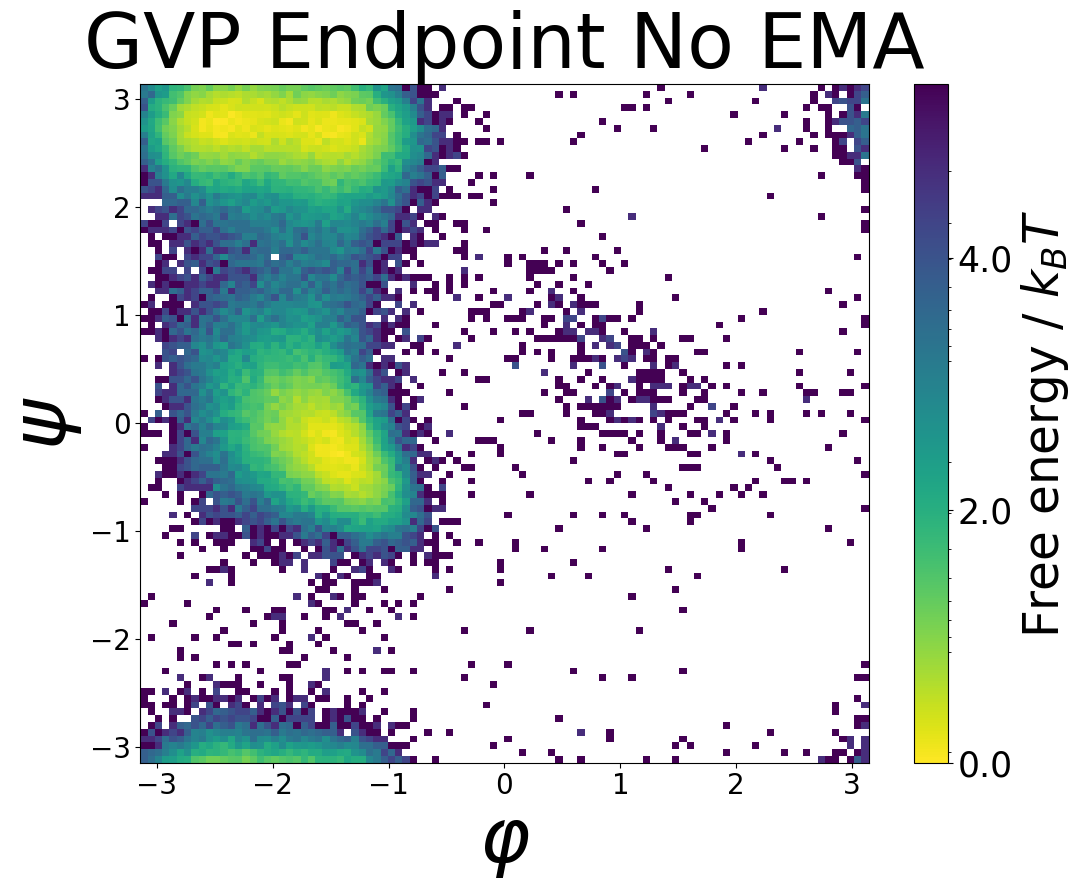

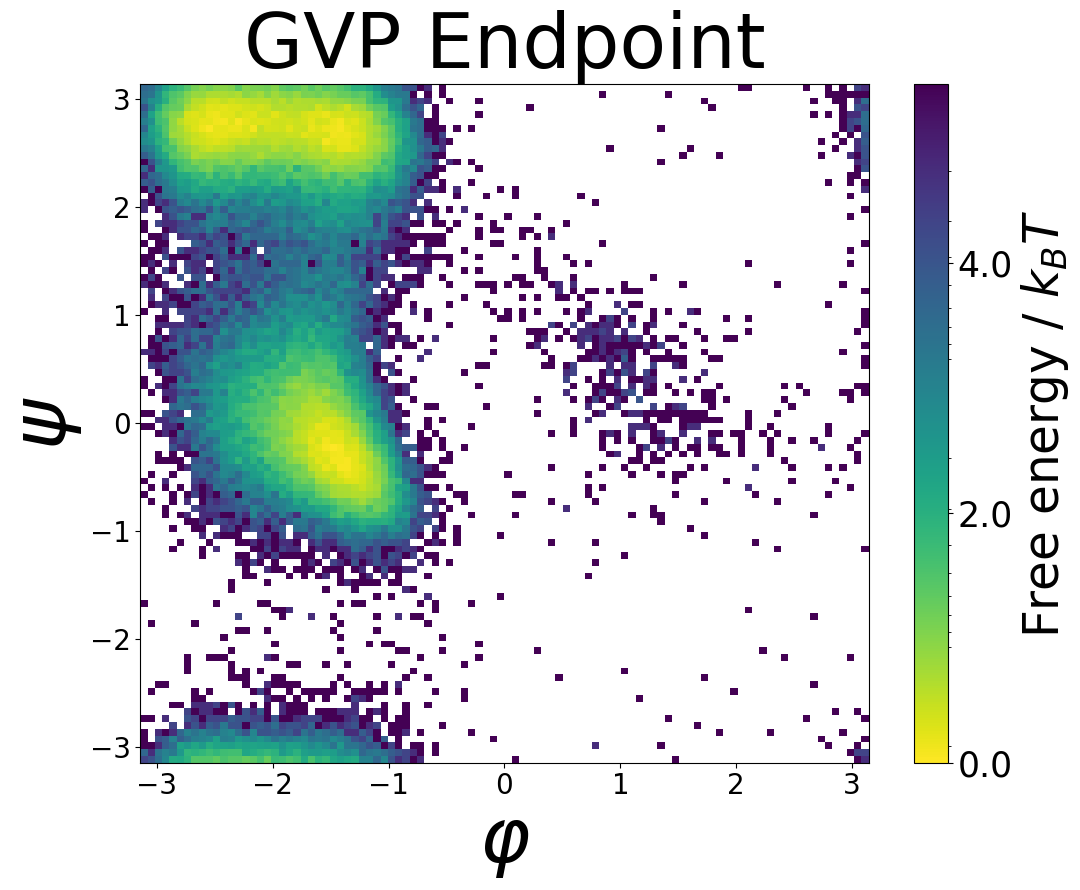

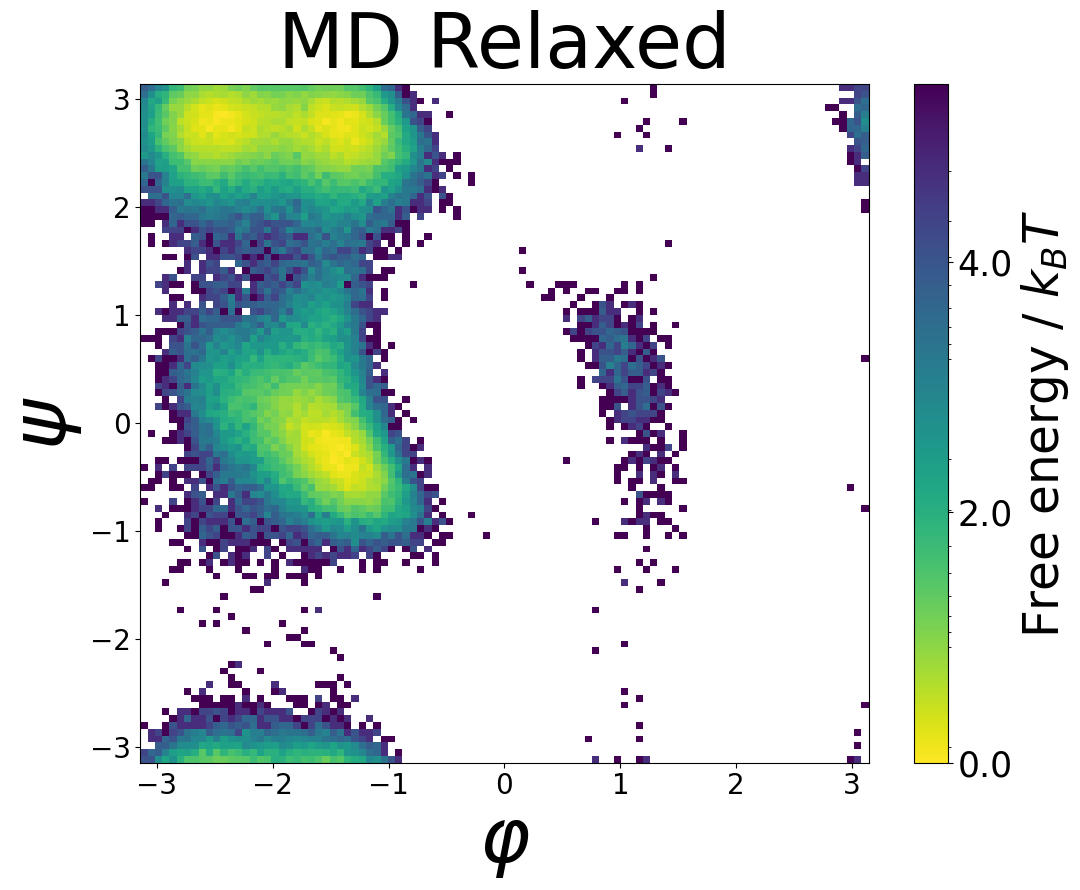

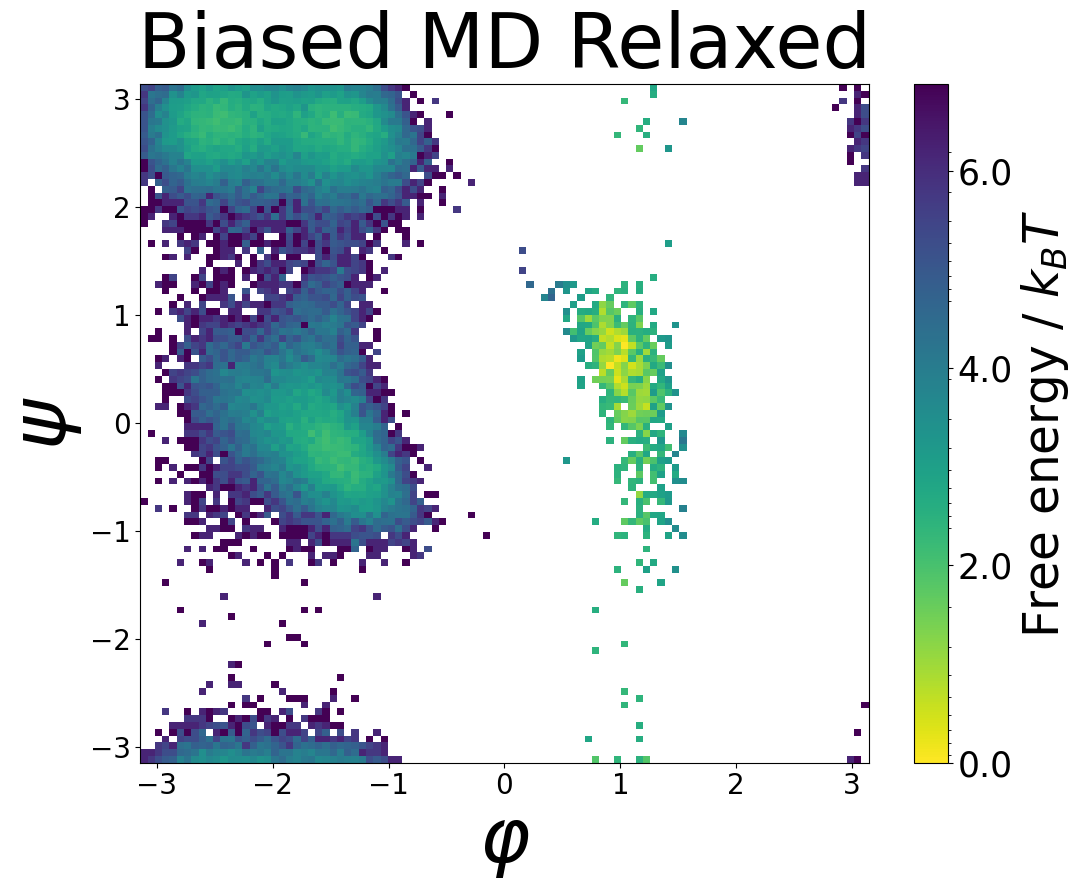

In [104]:


file_map = {
    "ECNF":        ("./generated/tbg_model_generated_energies.npy",      "./generated/tbg_model_generated_samples.npy"),
    "GVP Vector No EMA":     ("./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0energies_100k.npy",
                   "./generated/unweighted_ot_rtol1e-5_atol1e-5_tmin0_rep0samples_100k.npy"),
    "GVP Vector Field": ("./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0energies_100k.npy",
                   "./generated/unweighted_ot_ema_rtol1e-5_atol1e-5_tmin0_rep0samples_100k.npy"),
    "GVP Endpoint No EMA":   ("./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0energies_100k.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_rtol1e-5_atol1e-5_tmin1e-3_rep0samples_100k.npy"),
    "GVP Endpoint":("./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0energies_100k.npy",
                   "./generated/unweighted_ot_endpoint_tmax100_ema_rtol1e-5_atol1e-5_tmin1e-3_rep0samples_100k.npy"),
    "MD Relaxed": ("../data/energies_data_holdout_all.npy","../data/AD2_relaxed.npy"),
    "Biased MD Relaxed": ("../data/AD2_relaxed_weighted_all_energies.npy","../data/AD2_relaxed_weighted.npy")
}

for name, (e_path, s_path) in file_map.items():
    print(f"\n--- Processing model: {name} ---")
    energies = np.load(e_path)
    samples  = np.load(s_path)
    # uniform log‐weights → exp(log_w)=1
    log_w = np.zeros((energies.shape[0],))
    if name == "MD relaxed samples":
        samples  = np.load(s_path)[::9]
    
    
    plot_ramachandran(samples, energies, np.exp(log_w), title=name)
    # plot_free_energy_profile(samples, np.exp(log_w), title=name)